In [1]:
from birdcall.data import *
from birdcall.metrics import *

import pandas as pd

In [2]:
classes = pd.read_pickle('data/classes.pkl')
train_ds = MelspecPoolDataset(pd.read_pickle('data/train_set.pkl'), classes, len_mult=60)
valid_ds = MelspecPoolDataset(pd.read_pickle('data/val_set.pkl'), classes, len_mult=50)

In [3]:
len(train_ds), len(valid_ds)

(15840, 13200)

In [4]:
import torch
import torchvision
from torch import nn

In [5]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=NUM_WORKERS)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=2*16, shuffle=False, num_workers=NUM_WORKERS)

In [6]:
for b in train_dl: break
b[0].shape, b[1]

(torch.Size([16, 10, 3, 80, 212]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64))

In [7]:
b[0].mean(), b[0].std()

(tensor(-0.0536), tensor(0.8609))

In [8]:
def lme_pool(x, alpha=1.0): # log-mean-exp pool
    '''alpha -> approximates maxpool, alpha -> 0 approximates mean pool'''
    T = x.shape[1]
    mult_log = torch.log(torch.tensor(1/T))
    return 1/alpha * (mult_log + torch.logsumexp((alpha * x), dim=1))

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(*list(torchvision.models.resnet34(True).children())[:-2])
        self.classifier = nn.Sequential(*[
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(p=0.5), nn.BatchNorm1d(512),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(p=0.5), nn.BatchNorm1d(512),
            nn.Linear(512, len(classes))
        ])
        self.register_parameter('alpha', nn.Parameter(torch.tensor(1.)))
    
    def forward(self, x):
        bs, im_num, ch, y_dim, x_dim = x.shape
        x = self.cnn(x.view(-1, ch, y_dim, x_dim))
        x = x.mean((2,3))
        x = self.classifier(x)
        x = x.view(bs, im_num, -1)
        x = lme_pool(x, self.alpha)
        return x

In [10]:
model = Model().cuda()

In [11]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import time

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), 1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)

In [12]:
alphas = [model.alpha.item()]

t0 = time.time()
for epoch in range(130):
    
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        model.train()
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
    
    alphas.append(model.alpha.item())
    if epoch % 5 == 4:
        model.eval();
        preds = []
        targs = []

        with torch.no_grad():
            for data in valid_dl:
                inputs, labels = data[0].cuda(), data[1].cuda()
                outputs = model(inputs)
                preds.append(outputs.cpu().detach())
                targs.append(labels.cpu().detach())

            preds = torch.cat(preds)
            targs = torch.cat(targs)

        accuracy = accuracy_score(preds.sigmoid() > 0.5, targs)
        f1 = f1_score(preds.sigmoid() > 0.5, targs, average='micro')
        print(f'[{epoch + 1}, {(time.time() - t0)/60:.1f}] loss: {running_loss / (len(train_dl)-1):.3f}, acc: {accuracy:.3f}, f1: {f1:.3f}')
        running_loss = 0.0

        torch.save(model.state_dict(), f'models/{epoch}_lmepool_learned_alpha_{round(f1, 2)}.pth')

[5, 22.1] loss: 0.024, acc: 0.000, f1: 0.000
[10, 44.3] loss: 0.020, acc: 0.004, f1: 0.014
[15, 66.3] loss: 0.017, acc: 0.090, f1: 0.196
[20, 88.3] loss: 0.014, acc: 0.165, f1: 0.329
[25, 110.4] loss: 0.011, acc: 0.261, f1: 0.445
[30, 132.4] loss: 0.010, acc: 0.327, f1: 0.515
[35, 154.5] loss: 0.008, acc: 0.394, f1: 0.569
[40, 176.4] loss: 0.007, acc: 0.375, f1: 0.528
[45, 198.4] loss: 0.006, acc: 0.450, f1: 0.606
[50, 220.4] loss: 0.005, acc: 0.449, f1: 0.607
[55, 242.5] loss: 0.004, acc: 0.486, f1: 0.628
[60, 264.5] loss: 0.004, acc: 0.476, f1: 0.608
[65, 286.5] loss: 0.003, acc: 0.476, f1: 0.608
[70, 308.6] loss: 0.003, acc: 0.473, f1: 0.605
[75, 330.7] loss: 0.003, acc: 0.460, f1: 0.584
[80, 352.7] loss: 0.002, acc: 0.466, f1: 0.582
[85, 374.8] loss: 0.003, acc: 0.509, f1: 0.623
[90, 396.9] loss: 0.002, acc: 0.489, f1: 0.583
[95, 419.0] loss: 0.002, acc: 0.474, f1: 0.580
[100, 441.1] loss: 0.002, acc: 0.460, f1: 0.559
[105, 463.1] loss: 0.002, acc: 0.440, f1: 0.536
[110, 485.2] los

In [13]:
import numpy as np

f1s = []
ts = []
for t in np.linspace(0.4, 1, 61):
    f1s.append(f1_score(preds.sigmoid() > t, targs, average='micro'))
    ts.append(t)

In [14]:
max(f1s)

0.708347245409015

In [21]:
accuracy_score(preds.sigmoid() > ts[np.argmax(f1s)], targs)

0.6018181818181818

In [15]:
ts[np.argmax(f1s)]

0.98

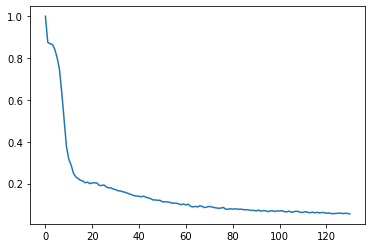

In [19]:
import matplotlib.pyplot as plt

plt.plot(alphas)